In [ ]:
# Install necessary libraries
!pip install torch torchvision timm tqdm scikit-learn seaborn

# Clone the GitHub repository
!rm -rf Iris-Flower-Classification
!git clone https://github.com/saptarshihalder/Iris-Flower-Classification.git

# Import libraries
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set device to CPU only
device = torch.device("cpu")
print("Using device:", device)

# Dataset directory
data_dir = "./Iris-Flower-Classification"

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []
        valid_extensions = (".jpg", ".jpeg", ".png")
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(valid_extensions):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls_name]))
        print(f"Loaded {len(self.samples)} samples from {root_dir}")
        print("Classes:", self.classes)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
image_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare datasets
dataset = CustomDataset(data_dir, transform=train_transform)
num_classes = len(dataset.classes)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Verify labels
for images, labels in train_loader:
    print("Labels batch:", labels)
    print("Unique labels:", torch.unique(labels))
    assert torch.all((labels >= 0) & (labels < num_classes)), "Labels out of range!"
    break

# Custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (image_size // 4) * (image_size // 4), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = CustomCNN(num_classes=num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)  # Only CPU usage
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Only CPU usage
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
        scheduler.step()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Cloning into 'Iris-Flower-Classification'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 420 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (420/420), 5.06 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Using device: cpu
Loaded 421 samples from ./Iris-Flower-Classification
Classes: ['.git', 'iris-setosa', 'iris-versicolour', 'iris-virginica']
Labels batch: tensor([2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 1, 2, 2])
Unique labels: tensor([1, 2, 3])


Epoch 1/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1: Train Loss: 5.1298, Val Loss: 1.1219, Val Accuracy: 0.6588


Epoch 2/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.9558, Val Loss: 0.9175, Val Accuracy: 0.6588


Epoch 3/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.8473, Val Loss: 0.9344, Val Accuracy: 0.6588


Epoch 4/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.7365, Val Loss: 0.8851, Val Accuracy: 0.6706


Epoch 5/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.6599, Val Loss: 0.8892, Val Accuracy: 0.6471


Epoch 6/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.6215, Val Loss: 0.8988, Val Accuracy: 0.6471


Epoch 7/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.5527, Val Loss: 0.8994, Val Accuracy: 0.6471


Epoch 8/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.5640, Val Loss: 0.9003, Val Accuracy: 0.6471


Epoch 9/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.6103, Val Loss: 0.8999, Val Accuracy: 0.6353


Epoch 10/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.5628, Val Loss: 0.9000, Val Accuracy: 0.6353


Class names: ['iris-setosa', 'iris-versicolour', 'iris-virginica']


Epoch 1/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1: Train Loss: 31.5957, Val Loss: 4.8198, Val Accuracy: 0.6235


Epoch 2/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2: Train Loss: 7.4855, Val Loss: 2.1141, Val Accuracy: 0.6588


Epoch 3/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3: Train Loss: 1.2114, Val Loss: 1.0709, Val Accuracy: 0.5059


Epoch 4/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.9300, Val Loss: 1.0478, Val Accuracy: 0.5647


Epoch 5/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.9207, Val Loss: 1.0430, Val Accuracy: 0.5765


Epoch 6/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.8856, Val Loss: 0.9912, Val Accuracy: 0.6118


Epoch 7/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.8654, Val Loss: 0.9928, Val Accuracy: 0.6235


Epoch 8/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.8553, Val Loss: 0.9875, Val Accuracy: 0.6353


Epoch 9/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.8725, Val Loss: 0.9880, Val Accuracy: 0.6353


Epoch 10/10 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.8278, Val Loss: 0.9888, Val Accuracy: 0.6353


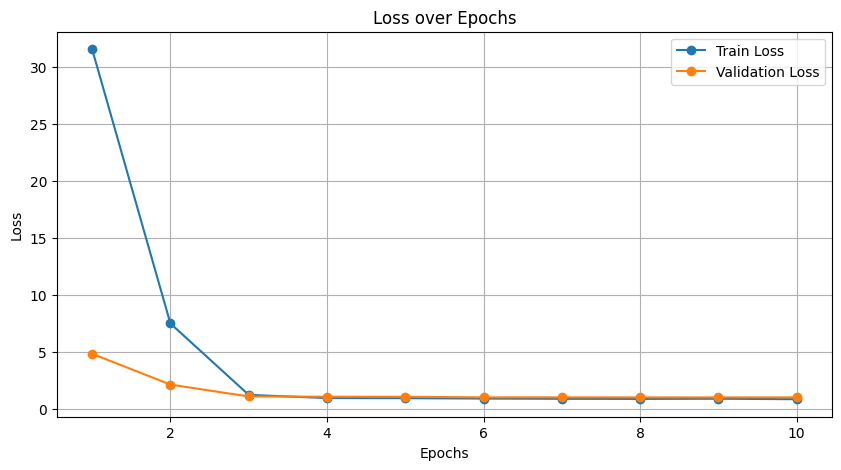

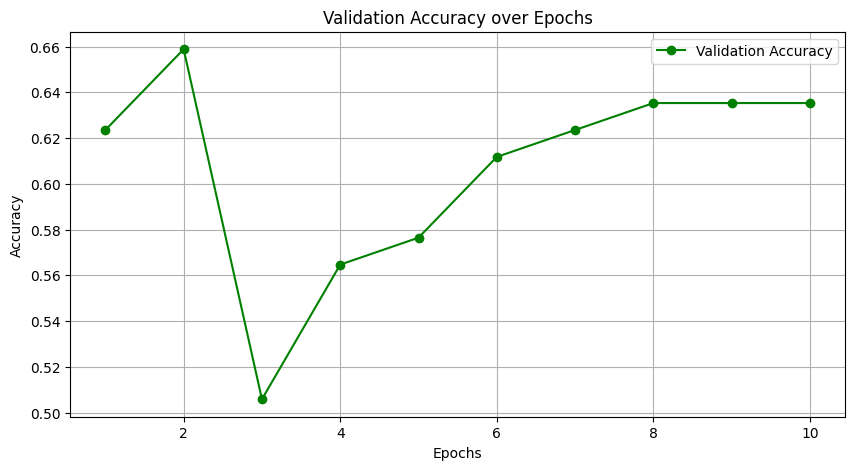

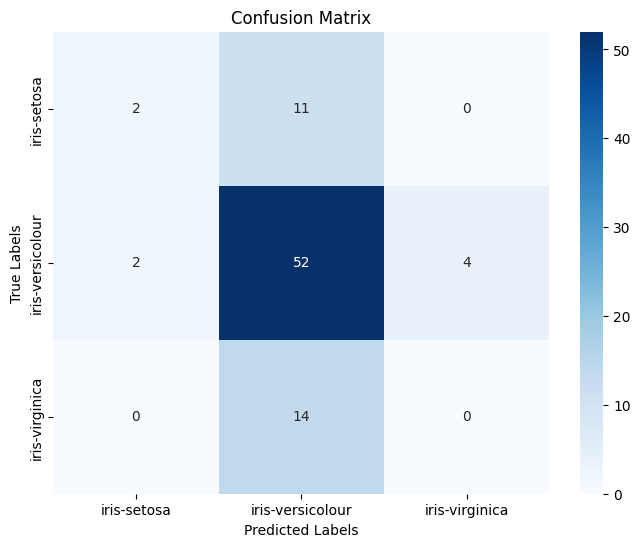


Classification Report:
                  precision    recall  f1-score   support

     iris-setosa       0.50      0.15      0.24        13
iris-versicolour       0.68      0.90      0.77        58
  iris-virginica       0.00      0.00      0.00        14

        accuracy                           0.64        85
       macro avg       0.39      0.35      0.34        85
    weighted avg       0.54      0.64      0.56        85



In [ ]:
# Plot metrics function
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Print classification report
def print_classification_report(true_labels, pred_labels, class_names):
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

# Updated training function to store metrics
def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, class_names=None):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())  # Corrected numpy() for CPU compatibility

        val_accuracy = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
        scheduler.step()

    # Generate plots
    plot_metrics(train_losses, val_losses, val_accuracies)
    plot_confusion_matrix(all_labels, all_preds, class_names)
    print_classification_report(all_labels, all_preds, class_names)

# Train and generate metrics
class_names = dataset.classes

# Ensure correct class names
assert len(class_names) == num_classes, (
    f"Mismatch in number of classes. Expected {num_classes}, got {len(class_names)}. "
    f"Class names: {class_names}"
)
print("Class names:", class_names)

train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, class_names=class_names)
